In [12]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error


In [13]:
# Load Spacy's NER model
nlp = spacy.load('en_core_web_sm')

# Loading the datasets
fake_df = pd.read_csv("politifact_fake.csv")
real_df = pd.read_csv("politifact_real.csv")

In [14]:
# labels: 0 for fake, 1 for real
fake_df['label'] = 0
real_df['label'] = 1


df = pd.concat([fake_df, real_df], ignore_index=True)


In [17]:
print(df.columns)
df = df[['id', 'news_url', 'title', 'tweet_ids', 'label']]

# Function to calculate news popularity based on tweet counts
def calculate_popularity(tweet_ids):
    if pd.isna(tweet_ids):
        return 0
    return len(str(tweet_ids).split())


Index(['id', 'news_url', 'title', 'tweet_ids', 'label'], dtype='object')


In [18]:
# Function to extract named entities
def extract_named_entities(text):
    doc = nlp(text)
    orgs = sum(1 for ent in doc.ents if ent.label_ == "ORG")
    persons = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
    gpe = sum(1 for ent in doc.ents if ent.label_ == "GPE")
    return pd.Series([orgs, persons, gpe])


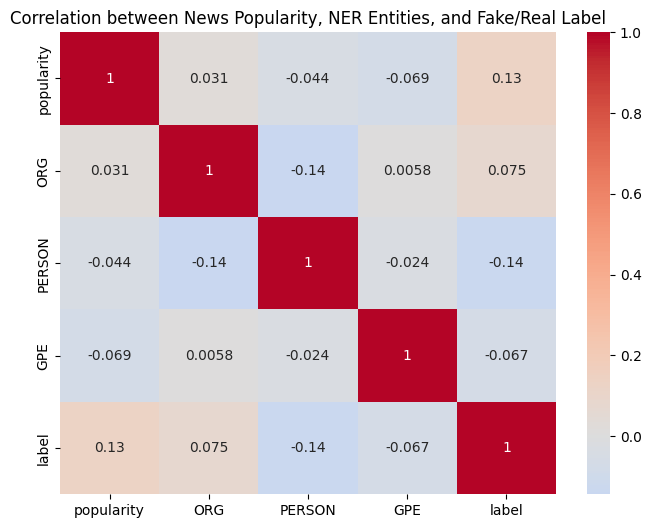

In [20]:
# Apply the functions
df['popularity'] = df['tweet_ids'].apply(calculate_popularity)
df[['ORG', 'PERSON', 'GPE']] = df['title'].apply(lambda x: extract_named_entities(str(x)))

# Drop rows with missing values
df = df.dropna()

# correlation matrix
correlation_matrix = df[['popularity', 'ORG', 'PERSON', 'GPE', 'label']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between News Popularity, NER Entities, and Fake/Real Label")
plt.show()



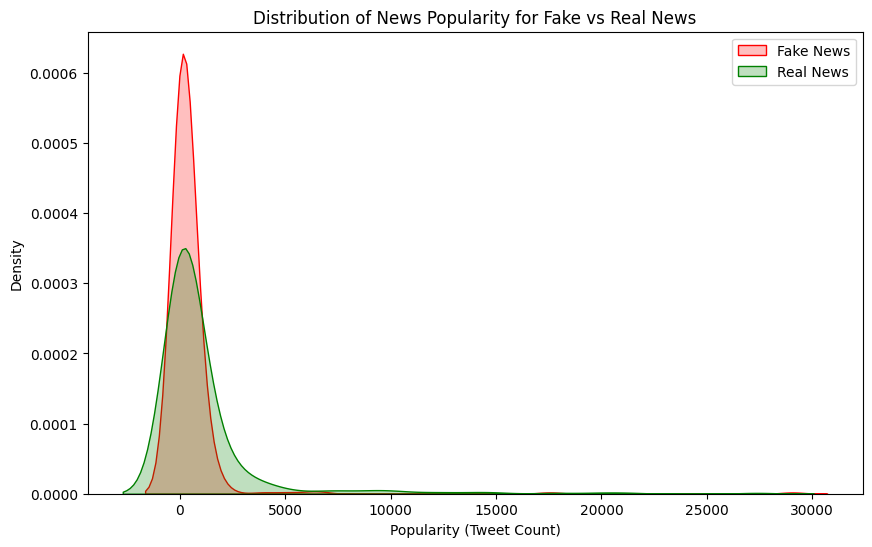

In [22]:
# Distribution of News Popularity for Fake vs Real News
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['label'] == 0]['popularity'], label='Fake News', fill=True, color='red')
sns.kdeplot(df[df['label'] == 1]['popularity'], label='Real News', fill=True, color='green')
plt.title("Distribution of News Popularity for Fake vs Real News")
plt.xlabel("Popularity (Tweet Count)")
plt.ylabel("Density")
plt.legend()
plt.show()



In [24]:
# NER Entity Counts for Fake vs Real News
ner_counts = df.groupby('label')[['ORG', 'PERSON', 'GPE']].sum().reset_index()
ner_counts['label'] = ner_counts['label'].map({0: 'Fake News', 1: 'Real News'})

Text(0, 0.5, 'Total Count')

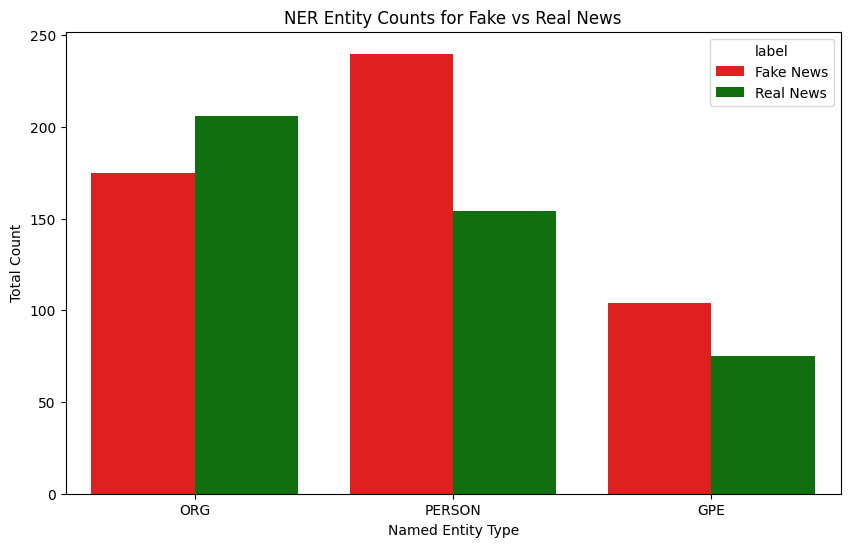

In [25]:
# plot for NER entity counts
ner_counts_melted = ner_counts.melt(id_vars='label', var_name='NER Entity', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='NER Entity', y='Count', hue='label', data=ner_counts_melted, palette=['red', 'green'])
plt.title("NER Entity Counts for Fake vs Real News")
plt.xlabel("Named Entity Type")
plt.ylabel("Total Count")